## POS-TAGGER

In [1]:
!pip install transformers

     |████████████████████████████████| 2.3MB 28.6MB/s 
     |████████████████████████████████| 3.3MB 47.7MB/s 
     |████████████████████████████████| 901kB 43.6MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.legacy
from torchtext.legacy import data
from torchtext import data
from torchtext import datasets
from torchtext.legacy.data.field import Field
from transformers import BertTokenizer, BertModel
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
import numpy as np

import time
import random
import functools

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [6]:
init_token = tokenizer.cls_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, pad_token, unk_token)

[CLS] [PAD] [UNK]


In [7]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, pad_token_idx, unk_token_idx)


101 0 100


In [8]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)


512


In [9]:
def cut_and_convert_to_id(tokens, tokenizer, max_input_length):
    tokens = tokens[:max_input_length-1]
    tokens = tokenizer.convert_tokens_to_ids(tokens)
    return tokens

In [10]:
def cut_to_max_length(tokens, max_input_length):
    tokens = tokens[:max_input_length-1]
    return tokens

In [11]:
text_preprocessor = functools.partial(cut_and_convert_to_id,
                                      tokenizer = tokenizer,
                                      max_input_length = max_input_length)

tag_preprocessor = functools.partial(cut_to_max_length,
                                     max_input_length = max_input_length)

In [12]:
TEXT = torchtext.legacy.data.Field(use_vocab = False,
                  lower = True,
                  preprocessing = text_preprocessor,
                  init_token = init_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

UD_TAGS = torchtext.legacy.data.Field(unk_token = None,
                     init_token = '<pad>',
                     preprocessing = tag_preprocessor)

In [13]:
fields = (("text", TEXT), ("udtags", UD_TAGS))


In [14]:
train_data, valid_data, test_data = torchtext.legacy.datasets.UDPOS.splits(fields)


downloading en-ud-v2.zip


en-ud-v2.zip: 100%|██████████| 688k/688k [00:00<00:00, 16.8MB/s]


extracting


In [15]:
print(len(train_data.examples))

12543


In [16]:
print(vars(train_data.examples[0]))


{'text': [2632, 1011, 100, 1024, 2137, 2749, 2730, 100, 14093, 2632, 1011, 100, 1010, 1996, 14512, 2012, 1996, 8806, 1999, 1996, 2237, 1997, 100, 1010, 2379, 1996, 9042, 3675, 1012], 'udtags': ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']}


In [17]:
UD_TAGS.build_vocab(train_data)

print(UD_TAGS.vocab.stoi)

defaultdict(None, {'<pad>': 0, 'NOUN': 1, 'PUNCT': 2, 'VERB': 3, 'PRON': 4, 'ADP': 5, 'DET': 6, 'PROPN': 7, 'ADJ': 8, 'AUX': 9, 'ADV': 10, 'CCONJ': 11, 'PART': 12, 'NUM': 13, 'SCONJ': 14, 'X': 15, 'INTJ': 16, 'SYM': 17})


In [18]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = torchtext.legacy.data.Iterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [19]:
class BERTPoSTagger(nn.Module):
    def __init__(self,
                 bert,
                 output_dim, 
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
  
        #text = [sent len, batch size]
    
        text = text.permute(1, 0)
        
        #text = [batch size, sent len]
        
        embedded = self.dropout(self.bert(text)[0])
        
        #embedded = [batch size, seq len, emb dim]
                
        embedded = embedded.permute(1, 0, 2)
                    
        #embedded = [sent len, batch size, emb dim]
        
        predictions = self.fc(self.dropout(embedded))
        
        #predictions = [sent len, batch size, output dim]
        
        return predictions

In [20]:
bert = BertModel.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
OUTPUT_DIM = len(UD_TAGS.vocab)
DROPOUT = 0.25

model = BERTPoSTagger(bert,
                      OUTPUT_DIM, 
                      DROPOUT)

In [22]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,496,082 trainable parameters


In [23]:
LEARNING_RATE = 5e-5

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [24]:
TAG_PAD_IDX = UD_TAGS.vocab.stoi[UD_TAGS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

In [25]:
model = model.to(device)
criterion = criterion.to(device)

In [26]:
def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]]).to(device)

In [27]:
def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.udtags
                
        optimizer.zero_grad()
        
        #text = [sent len, batch size]
        
        predictions = model(text)
        
        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]
        
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        #predictions = [sent len * batch size, output dim]
        #tags = [sent len * batch size]
        
        loss = criterion(predictions, tags)
                
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [28]:
def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # predicted=[]
    # true=[]
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.udtags
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            #predicted.append(predictions)
            tags = tags.view(-1)
            #true.append(tags)
            loss = criterion(predictions, tags)
            
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
val_losses = []
train_losses = []
val_accu=[]
train_accu=[]

In [31]:
%%time
N_EPOCHS = 5

best_valid_loss = float('inf')


for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)

    # train_losses.append(train_loss)
    # val_losses.append(valid_loss)
    # train_accu.append(train_acc)
    # val_accu.append(valid_acc)


    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 56s
	Train Loss: 0.390 | Train Acc: 88.77%
	 Val. Loss: 0.279 |  Val. Acc: 91.22%
Epoch: 02 | Epoch Time: 2m 2s
	Train Loss: 0.116 | Train Acc: 96.68%
	 Val. Loss: 0.269 |  Val. Acc: 91.68%
Epoch: 03 | Epoch Time: 2m 4s
	Train Loss: 0.076 | Train Acc: 97.78%
	 Val. Loss: 0.262 |  Val. Acc: 92.13%
Epoch: 04 | Epoch Time: 2m 6s
	Train Loss: 0.053 | Train Acc: 98.48%
	 Val. Loss: 0.272 |  Val. Acc: 92.12%
Epoch: 05 | Epoch Time: 2m 4s
	Train Loss: 0.039 | Train Acc: 98.86%
	 Val. Loss: 0.280 |  Val. Acc: 92.35%
CPU times: user 10min 5s, sys: 8.41 s, total: 10min 14s
Wall time: 10min 17s


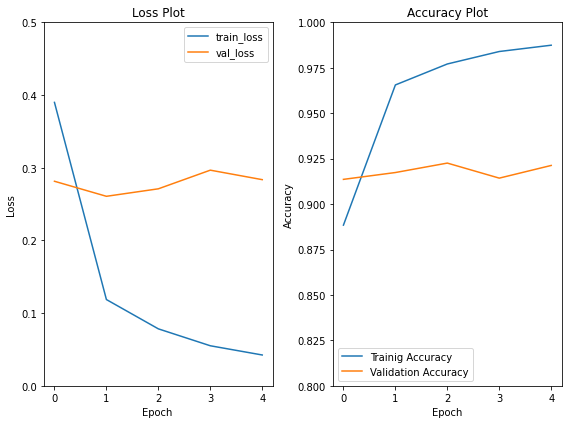

In [122]:
fig = plt.figure(figsize=(8,6))

plt.subplot(1, 2, 1) # row 1, col 2 index 
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.title("Loss Plot")
plt.xlabel('Epoch ')
plt.ylabel('Loss ')
plt.ylim([0, 0.5])
plt.legend()

plt.subplot(1, 2, 2) # index 2
plt.plot(train_accu, label='Trainig Accuracy')
plt.plot(val_accu,label='Validation Accuracy')
plt.title("Accuracy Plot")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.8, 1])

fig.tight_layout()
plt.show()

In [ ]:
#os.chdir('/content/')
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc,predictions, tags = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.281 | Test Acc: 90.96%


In [ ]:
len(predicted)

2378

In [ ]:
tag_pad_idx=0
tags_zero = [tag for tag in tags if tag != tag_pad_idx]

len(tags_zero)

1593

In [ ]:
predicted1=[tag1 for tag,tag1 in zip(tags,predicted) if tag != 0]
tags1=[tag for tag,tag1 in zip(tags,predicted) if tag != 0]
print(len(predicted1))
print(len(tags1))

1593
1593


In [ ]:
predictions[10:20]

tensor([[2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]], device='cuda:0')

In [ ]:
predictions.argmax(dim = 1, keepdim = True)[90]
predictions= predictions.argmax(dim = 1, keepdim = True)


In [ ]:
tags=[tag.cpu().numpy() for tag in tags]
predicted=[tag.cpu().numpy() for tag in predictions]

In [ ]:
def categorical_accuracy_test(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct

defaultdict(None,
            {'<pad>': 0,
             'ADJ': 8,
             'ADP': 5,
             'ADV': 10,
             'AUX': 9,
             'CCONJ': 11,
             'DET': 6,
             'INTJ': 16,
             'NOUN': 1,
             'NUM': 13,
             'PART': 12,
             'PRON': 4,
             'PROPN': 7,
             'PUNCT': 2,
             'SCONJ': 14,
             'SYM': 17,
             'VERB': 3,
             'X': 15})

In [ ]:
print(classification_report(tags1, predicted1, digits=4))

              precision    recall  f1-score   support

           1     0.9567    0.9266    0.9414       286
           2     0.9639    0.9816    0.9726       163
           3     0.9739    0.9675    0.9707       154
           4     0.9917    1.0000    0.9959       120
           5     0.9826    0.9941    0.9883       170
           6     1.0000    0.9850    0.9924       133
           7     0.8343    0.9338    0.8812       151
           8     0.9381    0.9286    0.9333        98
           9     0.9630    1.0000    0.9811        78
          10     0.9351    0.9730    0.9536        74
          11     1.0000    0.9623    0.9808        53
          12     0.9744    0.9500    0.9620        40
          13     0.9048    0.6129    0.7308        31
          14     0.9730    0.9474    0.9600        38
          15     0.0000    0.0000    0.0000         1
          17     1.0000    0.3333    0.5000         3

    accuracy                         0.9548      1593
   macro avg     0.8995   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
f1_score(tags,predicted, average='macro')

0.7681660673759534

In [ ]:
cm=confusion_matrix(tags1, predicted1)

In [ ]:
UD_TAGS.vocab.stoi
del UD_TAGS.vocab.stoi['<pad>']
UD_TAGS.vocab.stoi

defaultdict(None,
            {'ADJ': 8,
             'ADP': 5,
             'ADV': 10,
             'AUX': 9,
             'CCONJ': 11,
             'DET': 6,
             'INTJ': 16,
             'NOUN': 1,
             'NUM': 13,
             'PART': 12,
             'PRON': 4,
             'PROPN': 7,
             'PUNCT': 2,
             'SCONJ': 14,
             'SYM': 17,
             'VERB': 3,
             'X': 15})

In [ ]:
UD_TAGS.vocab.stoi.keys()

dict_keys(['NOUN', 'PUNCT', 'VERB', 'PRON', 'ADP', 'DET', 'PROPN', 'ADJ', 'AUX', 'ADV', 'CCONJ', 'PART', 'NUM', 'SCONJ', 'X', 'INTJ', 'SYM'])

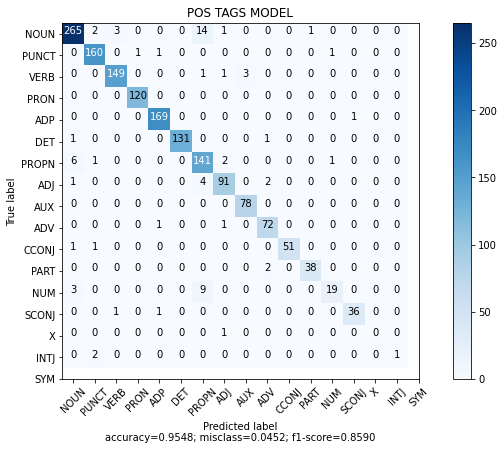

In [ ]:
plot_confusion_matrix(f1_score(tags1,predicted1,average='macro'), cm, UD_TAGS.vocab.stoi.keys(),title='POS TAGS MODEL',normalize=False)

In [ ]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

In [66]:
def tag_sentence(model, device, sentence, tokenizer, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        tokens = tokenizer.tokenize(sentence)
    else:
        tokens = sentence
    
    numericalized_tokens = tokenizer.convert_tokens_to_ids(tokens)
    numericalized_tokens = [text_field.init_token] + numericalized_tokens
        
    unk_idx = text_field.unk_token
    
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)
    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
         
    predictions = model(token_tensor)
    
    top_predictions = predictions.argmax(-1)
    
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    
    predicted_tags = predicted_tags[1:]
        
    assert len(tokens) == len(predicted_tags)
    
    return tokens, predicted_tags, unks

In [ ]:
sentence = 'Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks'

tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence,
                                  tokenizer,
                                  TEXT, 
                                  UD_TAGS)

print(unks)

[]


In [ ]:
print("Pred. Tag\tToken\n")

for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")


Pred. Tag	Token

ADJ		good
ADP		##mo
PROPN		##rn
NOUN		##ing
PUNCT		,
PRON		i
VERB		need
NUM		two
NOUN		v
NOUN		##ms
ADP		with
NUM		4
NOUN		cores
CCONJ		and
NUM		16
NOUN		##gb
ADP		of
NOUN		ram
DET		each
PUNCT		.
PRON		i
ADV		also
VERB		need
PRON		them
PART		to
VERB		have
DET		a
NUM		100
NOUN		##gb
NOUN		ss
NOUN		##d
NOUN		disk
PUNCT		.
ADJ		many
NOUN		thanks


In [ ]:
model=model.load_state_dict(torch.load('tut2-model.pt'))


### SCRAPING

In [ ]:
import wikipedia

In [ ]:
import gensim.downloader as api
corpus = api.load('text8')
from gensim.models.word2vec import Word2Vec
#model = Word2Vec(corpus)


[==================================================] 100.0% 31.6/31.6MB downloaded


In [ ]:
api.info("text8")

{'checksum': '68799af40b6bda07dfa47a32612e5364',
 'description': 'First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets.',
 'file_name': 'text8.gz',
 'file_size': 33182058,
 'license': 'not found',
 'num_records': 1701,
 'parts': 1,
 'read_more': ['http://mattmahoney.net/dc/textdata.html'],
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/text8/__init__.py',
 'record_format': 'list of str (tokens)'}

## MODEL

In [32]:
!pip install wikiextractor

     |████████████████████████████████| 51kB 7.0MB/s 


In [33]:
from string import Template
import random
from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer
from gensim.test.utils import get_tmpfile
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
from scipy.spatial import distance
import spacy
import re
import numpy as np
#Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
# load english language model
nlp = spacy.load('en_core_web_sm')
import spacy
from operator import itemgetter
from spacy import displacy 
#import visualise_spacy_tree
from IPython.display import Image, display
import collections
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
import os
os.chdir('/content/sample_data')
!pwd

/content/sample_data


In [35]:
!python -m wikiextractor.WikiExtractor Wikipedia-20210224120112.xml
!python -m wikiextractor.WikiExtractor Wikipedia-20210221155711.xml
!python -m wikiextractor.WikiExtractor Wikipedia-20210219102540.xml
!python -m wikiextractor.WikiExtractor Wikipedia-20210219161420.xml
!python -m wikiextractor.WikiExtractor Wikipedia-20210219103800.xml
!python -m wikiextractor.WikiExtractor Wikipedia-20210219103221.xml
!python -m wikiextractor.WikiExtractor Wikipedia-20210302170052.xml
!python -m wikiextractor.WikiExtractor Wikipedia-20210311193637.xml
!python -m wikiextractor.WikiExtractor Wikipedia-20210314114607.xml

INFO: Preprocessing 'Wikipedia-20210224120112.xml' to collect template definitions: this may take some time.
INFO: Loaded 0 templates in 0.0s
INFO: Starting page extraction from Wikipedia-20210224120112.xml.
INFO: Using 1 extract processes.
INFO: Finished 1-process extraction of 397 articles in 0.6s (639.0 art/s)
INFO: Preprocessing 'Wikipedia-20210221155711.xml' to collect template definitions: this may take some time.
INFO: Loaded 0 templates in 0.0s
INFO: Starting page extraction from Wikipedia-20210221155711.xml.
INFO: Using 1 extract processes.
INFO: Finished 1-process extraction of 745 articles in 1.2s (612.1 art/s)
INFO: Preprocessing 'Wikipedia-20210219102540.xml' to collect template definitions: this may take some time.
INFO: Loaded 0 templates in 0.0s
INFO: Starting page extraction from Wikipedia-20210219102540.xml.
INFO: Using 1 extract processes.
INFO: Finished 1-process extraction of 678 articles in 1.3s (513.2 art/s)
INFO: Preprocessing 'Wikipedia-20210219161420.xml' to c

In [36]:
os.chdir('/content')
os.chdir('/content/sample_data/text/AA')
!pwd

/content/sample_data/text/AA


In [37]:
tex=[]
for filename in os.listdir('/content/sample_data/text/AA'):
  with open(os.path.join('/content/sample_data/text/AA', filename)) as f:
      content = f.read()
      tex.append(content)

In [38]:
tex=' '.join(tex)

In [39]:


stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        #Removing digits
        document= re.sub(" \d+", " ", document)

        #removing # from bte pair encoding
        document= re.sub("#", " ", document)

        #removing recurrent headers
        headers=['doc id','curid','title']
        for header in headers:
          document= document.replace(header, '')

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 2]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [ ]:

plt.subplot(1, 2, 1) # row 1, col 2 index 
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.title("Loss Plot")
plt.xlabel('Epoch ')
plt.ylabel('Loss ')
plt.ylim([0, 0.5])
plt.legend()

plt.subplot(1, 2, 2) # index 2
plt.plot(train_accu, label='Trainig Accuracy')
plt.plot(val_accu,label='Validation Accuracy')
plt.title("Accuracy Plot")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.8, 1])

fig.tight_layout()
plt.show()

How many most common words to print: 10
computer :  2953
used :  2545
system :  2356
device :  2079
one :  1753
color :  1694
also :  1604
network :  1585
data :  1571
time :  1524


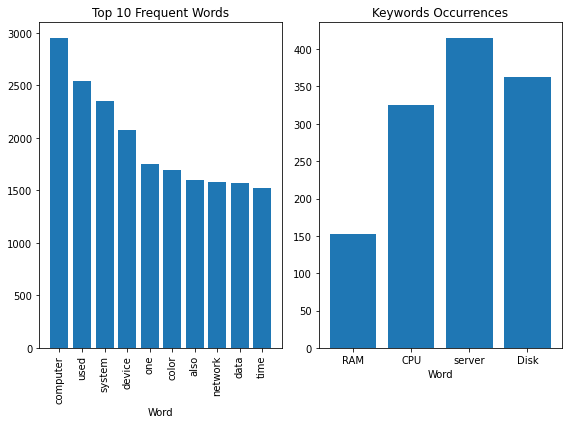

In [ ]:

wordcount = {}



n_print = int(input("How many most common words to print: "))
word_tokenized_c=[word for sentence in word_tokenized_corpus for word in sentence]
for word in word_tokenized_c:
  if word not in wordcount:
    wordcount[word] = 1
  else:
    wordcount[word] += 1
word_counter = collections.Counter(wordcount)
for word, count in word_counter.most_common(n_print):
    print(word, ": ", count)

lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])

lst1=[['RAM',153],['CPU',325],['server',415],['Disk',362]]
df1 = pd.DataFrame(lst1, columns = ['Word', 'Count'])

# Create a data frame of the most common words 
# Draw a bar chart

fig = plt.figure(figsize=(8,6))

plt.subplot(1, 2, 1)
plt.bar(df.Word,height=df.Count)
plt.xlabel('Word')
plt.xticks(rotation=90)
plt.title("Top 10 Frequent Words")


plt.subplot(1, 2, 2)
plt.bar(df1.Word,height=df1.Count)
plt.xlabel('Word')
plt.title("Keywords Occurrences")

fig.tight_layout()
plt.show()



In [ ]:
import nltk
from nltk.corpus.util import LazyCorpusLoader
from nltk.corpus.reader import *
webtext = LazyCorpusLoader(
    "reuters", PlaintextCorpusReader, r"(?!README|\.).*\.txt", encoding="ISO-8859-2"
)

In [ ]:
nlt=nltk.corpus.webtext.words()

In [ ]:
all=[word for sentence in nlt for word in sentence]
len(all)

1409474

'Manager'

In [ ]:

tokens = [stemmer.lemmatize(word) for word in nlt]
tokens = [word for word in tokens if word not in en_stop]
tokens = [word for word in tokens if len(word) > 3]


In [ ]:
from collections import Counter
words_to_count = (word.lower() for word in tokens)
c = Counter(words_to_count)
#print(c.most_common(10))
lst=c.most_common(10)

In [ ]:
our_words=[['RAM',2],['CPU',12],['server',41],['disk',30]]

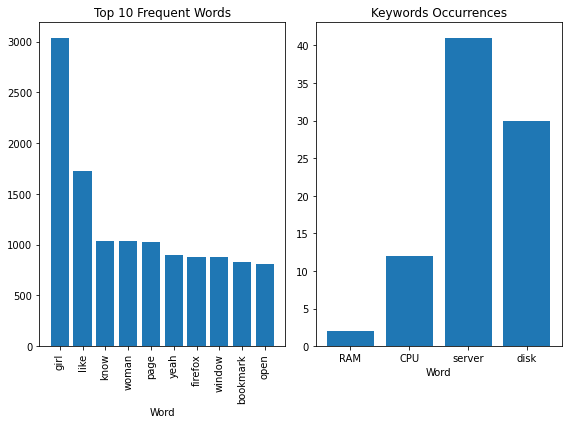

In [ ]:
#lst = word_counter.most_common(n_print)
df = pd.DataFrame(lst, columns = ['Word', 'Count'])

lst1=[['RAM',153],['CPU',325],['server',415],['Disk',362]]
df2 = pd.DataFrame(our_words, columns = ['Word', 'Count'])

# Create a data frame of the most common words 
# Draw a bar chart

fig = plt.figure(figsize=(8,6))

plt.subplot(1, 2, 1)
plt.bar(df.Word,height=df.Count)
plt.xlabel('Word')
plt.xticks(rotation=90)
plt.title("Top 10 Frequent Words")


plt.subplot(1, 2, 2)
plt.bar(df2.Word,height=df2.Count)
plt.xlabel('Word')
plt.title("Keywords Occurrences")

fig.tight_layout()
plt.show()


In [ ]:
all=[word for sentence in word_tokenized_corpus for word in sentence]
len(all)

In [40]:
contents=sent_tokenize(tex)
final_corpus = [preprocess_text(sentence) for sentence in contents if sentence.strip() !='']

word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]

In [41]:
embedding_size = 60
window_size = 40
min_word = 30
down_sampling = 1e-2

In [42]:
%%time
ft_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      iter=100)

CPU times: user 21min 46s, sys: 1.84 s, total: 21min 48s
Wall time: 11min 7s


In [12]:
# Store just the words + their trained embeddings.
word_vectors = ft_model.wv
word_vectors.save("word2vec.wordvectors")

In [14]:
#load_embeddings
import os
os.chdir('/content/sample_data/text/AA/')
ft_model_sg = KeyedVectors.load("word2vec.wordvectors", mmap='r')

In [18]:
ft_model.wv.vectors= [i / np.sqrt(np.sum(i**2)) for i in ft_model.wv.vectors]

In [23]:
ft_model_sg.wv.vectors[1].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


-0.0001965098

In [ ]:
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=20)]
                  for words in ['king']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

king:['created', 'supporting', 'trunking', 'part', 'well', 'system', 'vision', 'initially', 'application', 'developed', 'several', 'also', 'released', 'feature', 'networking', 'support', 'virtual', 'kind', 'early', 'bonding']


In [ ]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
glove_vectors.distance('ram','memory')

0.37997162342071533

In [ ]:
ft_model.wv.most_similar('server',topn=15)


[('client', 0.8105968832969666),
 ('web', 0.7108408808708191),
 ('host', 0.683346152305603),
 ('node', 0.650037407875061),
 ('internet', 0.6440026760101318),
 ('service', 0.6341893076896667),
 ('cloud', 0.6295466423034668),
 ('desktop', 0.6293352842330933),
 ('application', 0.6241844892501831),
 ('enterprise', 0.6230933666229248),
 ('network', 0.6098619103431702),
 ('load', 0.6089855432510376),
 ('fabric', 0.6089115142822266),
 ('managed', 0.6040304899215698),
 ('traditional', 0.6004859805107117)]

In [ ]:
def append_list(sim_words, words):
    
    list_of_words = []
    
    for i in range(len(sim_words)):
        
        sim_words_list = list(sim_words[i])
        sim_words_list.append(words)
        sim_words_tuple = tuple(sim_words_list)
        list_of_words.append(sim_words_tuple)
        
    return list_of_words

input_word = ['server','ram','cpu','disk']
user_input = [x.strip() for x in input_word]
result_word = []
    
for words in user_input:
    
        sim_words = ft_model.wv.most_similar(words, topn = 15)
        sim_words = append_list(sim_words, words)
            
        result_word.extend(sim_words)
    
similar_word = [word[0] for word in result_word]
similarity = [word[1] for word in result_word] 
similar_word.extend(user_input)
labels = [word[2] for word in result_word]
label_dict = dict([(y,x+1) for x,y in enumerate(set(labels))])
color_map = [label_dict[x] for x in labels]

In [ ]:
similar_word

['client',
 'web',
 'host',
 'node',
 'internet',
 'service',
 'cloud',
 'desktop',
 'application',
 'enterprise',
 'network',
 'load',
 'fabric',
 'managed',
 'traditional',
 'memory',
 'rom',
 'chip',
 'stored',
 'ultrasound',
 'limitation',
 'onboard',
 'video',
 'ddr3',
 'vic',
 'featured',
 'bitmap',
 'additional',
 'magnetic',
 'card',
 'processor',
 'processing',
 'memory',
 'core',
 'board',
 'interrupt',
 'gpus',
 'chip',
 'execution',
 'x86',
 'intel',
 'gpu',
 'peripheral',
 'bus',
 'architecture',
 'drive',
 'hard',
 'floppy',
 'storage',
 'sector',
 'file',
 'flash',
 'write',
 'tape',
 'loaded',
 'magnetic',
 'system',
 'ssd',
 'ssds',
 'seek',
 'server',
 'ram',
 'cpu',
 'disk']

In [ ]:
import plotly
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

def display_pca_scatterplot_3D(model, user_input=None, words=None, label=None, color_map=None, topn=15, sample=10):

    # if words == None:
    #     if sample > 0:
    #         words = np.random.choice(list(model.vocab.keys()), sample)
    #     else:
    #         words = [ word for word in model.vocab ]
    
    word_vectors = np.array([model[w] for w in words])
    
    three_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:3]
    # For 2D, change the three_dim variable into something like two_dim like the following:
    # two_dim = PCA(random_state=0).fit_transform(word_vectors)[:,:2]

    data = []
    count = 0
    
    for i in range (len(user_input)):

                trace = go.Scatter3d(
                    x = three_dim[count:count+topn,0], 
                    y = three_dim[count:count+topn,1],  
                    z = three_dim[count:count+topn,2],
                    text = words[count:count+topn],
                    name = user_input[i],
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 0.8,
                        'color': 2
                    }
       
                )
                
                # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable. Also, instead of using
                # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
                data.append(trace)
                count = count+topn

    trace_input = go.Scatter3d(
                    x = three_dim[count:,0], 
                    y = three_dim[count:,1],  
                    z = three_dim[count:,2],
                    text = words[count:],
                    name = 'keywords',
                    textposition = "top center",
                    textfont_size = 20,
                    mode = 'markers+text',
                    marker = {
                        'size': 10,
                        'opacity': 1,
                        'color': 'black'
                    }
                    )

    # For 2D, instead of using go.Scatter3d, we need to use go.Scatter and delete the z variable.  Also, instead of using
    # variable three_dim, use the variable that we have declared earlier (e.g two_dim)
            
    data.append(trace_input)
    
# Configure the layout

    layout = go.Layout(
        margin = {'l': 0, 'r': 0, 'b': 0, 't': 0},
        showlegend=True,
        legend=dict(
        x=1,
        y=0.5,
        font=dict(
            family="Courier New",
            size=25,
            color="black"
        )),
        font = dict(
            family = " Courier New ",
            size = 15),
        autosize = False,
        width = 1000,
        height = 1000
        )


    plot_figure = go.Figure(data = data, layout = layout)
    plot_figure.show()


display_pca_scatterplot_3D(ft_model, user_input, similar_word, labels, color_map)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [ ]:
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=10)]
                  for words in ['hard','host','machine','process','software','computer','wardrobe','ticket','sun','light','iron',
                                'planet','roman','cosmic','roman','british','jacket','america','football','car']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

hard:['drive', 'disk', 'flash', 'ssds', 'storage', 'volume', 'external', 'performance', 'scsi', 'internal']
host:['network', 'server', 'virtualized', 'firmware', 'hba', 'iscsi', 'zoning', 'access', 'client', 'device']
machine:['computer', 'built', 'made', 'electronic', 'could', 'mechanical', 'war', 'british', 'calculator', 'early']
process:['step', 'needed', 'system', 'need', 'information', 'execute', 'automated', 'program', 'like', 'configuration']
software:['hardware', 'user', 'open', 'support', 'application', 'free', 'driver', 'developer', 'capability', 'documentation']
computer:['early', 'built', 'electronic', 'designed', 'first', 'used', 'successor', 'modern', 'purpose', 'developed']
wardrobe:['robert', 'basis', 'war', 'development', 'united', 'important', 'british', 'initially', 'developing', 'army']
ticket:['stick', 'socket', 'packet', 'pocket', 'mini', 'like', 'tcp', 'frame', 'traffic', 'programmable']
sun:['gear', 'moon', 'pointer', 'dial', 'planet', 'date', 'lunar', 'astronom

In [ ]:
from sklearn.decomposition import PCA

all_similar_words = [k  for k in semantically_similar_words.values()]
all_similar_words=[item for sublist in all_similar_words for item in sublist]
print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

['drive', 'disk', 'flash', 'ssds', 'storage', 'volume', 'external', 'performance', 'scsi', 'internal', 'network', 'server', 'virtualized', 'firmware', 'hba', 'iscsi', 'zoning', 'access', 'client', 'device', 'computer', 'built', 'made', 'electronic', 'could', 'mechanical', 'war', 'british', 'calculator', 'early', 'step', 'needed', 'system', 'need', 'information', 'execute', 'automated', 'program', 'like', 'configuration', 'hardware', 'user', 'open', 'support', 'application', 'free', 'driver', 'developer', 'capability', 'documentation', 'early', 'built', 'electronic', 'designed', 'first', 'used', 'successor', 'modern', 'purpose', 'developed', 'robert', 'basis', 'war', 'development', 'united', 'important', 'british', 'initially', 'developing', 'army', 'stick', 'socket', 'packet', 'pocket', 'mini', 'like', 'tcp', 'frame', 'traffic', 'programmable', 'gear', 'moon', 'pointer', 'dial', 'planet', 'date', 'lunar', 'astronomical', 'calendar', 'face', 'pen', 'button', 'beam', 'pressed', 'instrume

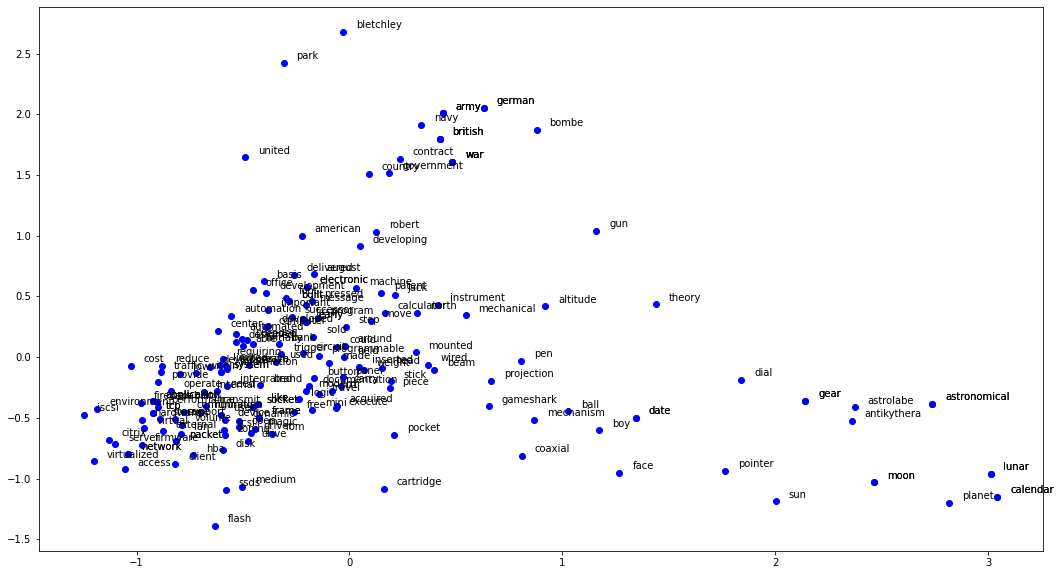

In [ ]:
word_vectors = ft_model.wv[all_similar_words]


pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='blue')


for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

# for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
#     comp = comp * var  # scale component by its variance explanation power
#     plt.plot([0, comp[0]], [0, comp[1]], label=f"Component {i}", linewidth=5,color=f"C{i + 2}")
# plt.legend()

In [ ]:
import os
os.chdir('./sample_data/')
os.getcwd()

'/content/sample_data'

In [ ]:
data=Convert(data)

In [ ]:
for x in data:
  print(x, end=', ')

In [ ]:
def Convert(string):
    li = list(string.split(" "))
    return li
  
# Driver code    

#print(Convert(category_list))

In [ ]:
ft_model.wv.doesnt_match(['computer','nights','cpu'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'nights'

In [ ]:
from collections import defaultdict

storage=defaultdict(list)
keys=['server','cpu','ram','disk']
for i in keys:
  for k in ft_model.wv.most_similar(i):
    storage[i].append(k)


In [43]:
def pos_tagging(sentence): 
  tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence,
                                  tokenizer,
                                  TEXT, 
                                  UD_TAGS)
  return tokens, tags

# print(unks)
# print("Pred. Tag\tToken\n")

# for token, tag in zip(tokens, tags):
#     print(f"{tag}\t\t{token}")

In [44]:
def is_noun_tag(tokens,tags):
  candidates=[]
  for token, tag in zip(tokens, tags):
    if tag =='NOUN':
      candidates.append(preprocess_text(token))
  return candidates
#candidates=is_noun_tag(sentence)

#is_noun_tag(tokens,tags)

In [45]:
def is_noun_tag(tokens,tags):
  candidates=[]
  for token, tag in zip(tokens, tags):
    if tag =='NOUN':
      candidates.append(preprocess_text(token))
  return [elem for elem in candidates if elem.strip()]

# candidates=is_noun_tag(trial_sentence)

# candidates

In [46]:
def is_noun(doc):
  candidates=[]
  for tok in doc:
    if tok.tag_ =='NNP' or tok.tag_=='NNS' or tok.tag_== 'NN':
      candidates.append(preprocess_text(tok.text))
  return candidates

#candidates=is_noun(doc)

In [47]:
def word_in_vocab(word):
  vocab=ft_model.wv.vocab
  return word in vocab

#word_in_vocab('')

In [48]:
#Sentencizer
class DummySentencizer:
  def __init__(self, input_text, split_characters=[',','.'], delimiter_token='<SPLIT>'):       
        self.sentences = []
        self.raw = str(input_text)
        self._split_characters=split_characters
        self._delimiter_token=delimiter_token
        self._index=0
        self._sentencize()
  def _sentencize(self):
      work_sentence = self.raw
      for character in self._split_characters:
        work_sentence = work_sentence.replace(character, character+""+self._delimiter_token)
      self.sentences = [x.strip() for x in work_sentence.split(self._delimiter_token) if x !='']
  def __iter__(self):
       return self
  def __next__(self):
    if self._index < len(self.sentences):
        result = self.sentences[self._index]
        self._index+=1
        return result
    raise StopIteration

In [49]:
def closest_sentence(sentence_list,key='ram'):
  candidates=[]
  for sentence in sentence_list:
    candidates.append([sentence,max([ft_model.wv.similarity(preprocess_text(word),key) for word in sentence.split() if word_in_vocab(preprocess_text(word))==True],default=0)])
  
  return max(candidates,key=itemgetter(1))[0]
  
# ram_sentence=closest_sentence(sentences)

In [50]:
def remove_adp_of(sentence,adp='of'):
  if adp in sentence.split():
    sentence=sentence.replace(adp,'')
  else:
    pass
  return ' '.join(sentence.split())

In [51]:
def find_num(text,key,threshold_num=0.5):
  candidates=[]
  doc=nlp(text)
  for token in doc:
    if (token.dep_=='nummod'):
      candidates.append([token.text,token.head.text])
  #apply filter for too distant words, which in turn will not be related to word of interest
  candidates=[candidate for candidate in candidates if word_in_vocab(preprocess_text(candidate[1]))==True]
  candidates=[candidate for candidate in candidates if ft_model.wv.similarity(preprocess_text(candidate[1]),key)>threshold_num]

  return candidates

# ls=find_num(ram_sentence)

In [52]:
def find_num_cores(doc):
  candidates=[]
  for token in doc:
    if (token.dep_=='nummod'):
      candidates.append([token.text,token.head.text])
  candidates=similarity_threshold(candidates,threshold)
  return candidates

#ls=find_num_cores(doc)

In [53]:
def similarity_threshold(best,num,key,threshold):
    if ft_model.wv.similarity(best,key)<threshold:
      return [None,None]
    else:
      return [num, best]

In [54]:
# def sentence_similarity_threshold(best,num,key,threshold=0.41):
#     if ft_model.wv.similarity(best,key)<threshold:
#       return [None,None]
#     else:
#       return [num, best]

In [55]:
def find_gb(ls,key):
  possible=[]
  [possible.append([ft_model.wv.similarity(preprocess_text(tok[1]),key),tok[0]]) for tok in ls if word_in_vocab(preprocess_text(tok[1]))==True]
  #filter far away words
  #possible=similarity_threshold(possible)

  if possible:
    return max(possible, key=lambda x: x[0])[1]
  else:
    pass

#find_diskgb(ls)

In [56]:
def find_server_name(doc):
  candidates=[]
  for tok in doc:
    if tok.dep_ =='appos':
      candidates.append(preprocess_text(tok.text))
  return candidates

In [57]:

def best_candidate(candidates,key):
  sims=[]
  discarded=[]
  [discarded.append(cand) for cand in candidates if word_in_vocab(cand)==False]
  candidates=[i for i in candidates if i not in discarded]
  [sims.append([ft_model.wv.similarity(w,key),w]) for w in candidates]
  
  if sims:
      return max(sims, key=lambda x: x[0])[1]
  else:
      pass
  

#best_candidate_processor(candidates)
  

## FINDING CORES

In [ ]:
def find_num_of_processors(ls,key='processor'):
  processors=[]
  [processors.append([ft_model.wv.similarity(preprocess_text(tok[1]),key),tok[0]]) for tok in ls if word_in_vocab(preprocess_text(tok[1]))==True ]
  #10 most similar words for item
  most_similar=ft_model.wv.most_similar([key], topn=10)
  most_similar=[item[0] for item in most_similar]
  #[sims.remove(sim) for sim in sims if sim[1] not in most_similar]
  processors=[item[0] for item in ls if preprocess_text(item[1]) in most_similar]
  if processors:
    return max(processors, key=lambda x: x[0])
  else:
    pass

#find_num_of_processors(ls)

In [58]:
def find_cpu_cores(text,threshold=0.6,key='processor'):
  
    names = []
    tokens,tags=pos_tagging(text)
    # spacy doc
    doc = nlp(text)
    #finding cores
    text=preprocess_text(text)
    noun_candidates=is_noun_tag(tokens, tags)    
                   
    best=best_candidate(noun_candidates,key)
    
    #finding number of cores
    sentencizer=DummySentencizer(doc)

    sentences=sentencizer.sentences

    cpu_sentence=closest_sentence(sentences,key)

    cpu_sentence=remove_adp_of(cpu_sentence)

    num_candidates=find_num(cpu_sentence,key,threshold)

    num_processors=find_gb(num_candidates,key)

    num,best=similarity_threshold(best,num_processors,key,threshold)
    return [num, best]

#find_cpu_cores(sentence)

    



In [ ]:
for sent in tickets:
  print(sent,find_cpu_cores(sent,0.6))

In [ ]:
for sent in tickets:
  print(sent,find_cpu_cores(sent,0.6))

Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks ['4', 'core']
Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks ['4', 'cpu']
Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks [None, 'core']
Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks ['4', 'core']
Hello, I need 6 machines with 32GB or RAM each. Thanks [None, None]
Hello, for an important project which will be delivered on 24th March, I need a full MySQL database with 150GBs of disk. The server needs to be able to sustain 1000 qps. Thanks [None, None]
Hi, I need a server. [None, None]
Is this the right place to ask for a 2 cpu, 16G of RAM, 128 SSD? Many thanks ['2', 'cpu']
Hello, since the launch of the new project, the cluster is s

In [ ]:
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [ ]:
actual_cores=[['4', 'core'],['4', 'cpu'],[None, 'core'],['4', 'core'],[None, None],[None, None],[None, None],['2', 'cpu'],[None, None],[None, None],['4', 'core'],['4', 'cpu'],[None, None]]
actual_ram=[['16', 'ram'],['32', 'memory'],[None, 'gb'],['16', 'ram'],['32', 'ram'],[None, None],[None, None],['16', 'ram'],[None, None],[None, None],[None,None],['16', 'memory'],['24', 'ram']]
actual_disk=[['100', 'disk'],['1', 'disk'],[None, 'disk'],['100', 'disk'],[None, None],['150GBs', 'disk'],[None, None],['128', 'ssd'],[None, None],['100', 'disk'],[None, None], [None, None],['50', 'disk']]
actual_server=[[None, None],['1', 'server'],[None, None],[None, None],[None, None],[1, 'server'],[1, 'server'],[None, None],['4', 'server'],[1, 'server'],[1, 'load'], [1, 'server'],['3', 'server']]

In [ ]:
thresholds=np.linspace(0,1,11)

In [ ]:
def grid_search_threshold(tickets,thresholds,function,actual_res):
  predicted=[]
  for ticket in tickets:
    for i in thresholds:
      predicted.append([function(ticket,i),i])
  values = set(map(lambda x:x[1],predicted))
  predicted = [[y[0] for y in predicted if y[1]==x] for x in values]
  acc=[]
  for i in range(len(thresholds)):
    acc.append([accuracy_metric(actual_res,predicted[i]),thresholds[i]])
  return max(acc, key=lambda x: x[0])

In [ ]:
grid_search_threshold(tickets,thresholds,find_server,actual_server)

[53.84615384615385, 0.5]

In [ ]:
def find_num(text,key,threshold_num=0.4):
  candidates=[]
  doc=nlp(text)
  for token in doc:
    if (token.dep_=='nummod'):
      candidates.append([token.text,token.head.text])
  #apply filter for too distant words, which in turn will not be related to word of interest
  candidates=[candidate for candidate in candidates if word_in_vocab(preprocess_text(candidate[1]))==True]
  candidates=[candidate for candidate in candidates if ft_model.wv.similarity(preprocess_text(candidate[1]),key)>threshold_num]

  return candidates


In [ ]:
grid_search_threshold(find_num,thresholds,find_disk,actual_disk)

## FINDING RAM MEMORY

In [ ]:
# test_sentence='Is this the right place to ask for a 2 cpu, 16GB of RAM, 128 of SSD? Many thanks'
# doc=nlp(test_sentence)

# for chunk in doc.noun_chunks:
#   print(chunk.text, chunk.root.text, chunk.root.dep_,
#             chunk.root.head.text)

In [59]:
def find_ram(ticket,threshold=0.5,key='ram'):

    names = []
    tokens,tags=pos_tagging(ticket)
    # spacy doc
    doc = nlp(ticket)
    #finding cores

    noun_candidates=is_noun_tag(tokens,tags)    
                   
    best=best_candidate(noun_candidates,key)
    
    #finding gigabytes of ram
    sentencizer=DummySentencizer(doc)

    sentences=sentencizer.sentences

    ram_sentence=closest_sentence(sentences)

    ram_sentence=remove_adp_of(ram_sentence)

    numerical_candidates=find_num(ram_sentence,key)

    num=find_gb(numerical_candidates,key)

    num,best=similarity_threshold(best,num,key,threshold)

    return [num, best]

# find_ram(trial_sentence)


In [ ]:
for sent in tickets:
  print(sent,find_ram(sent))

Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks ['16', 'ram']
Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks ['32', 'memory']
Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks [None, None]
Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks ['16', 'ram']
Hello, I need 6 machines with 32GB or RAM each. Thanks [None, 'ram']
Hello, for an important project which will be delivered on 24th March, I need a full MySQL database with 150GBs of disk. The server needs to be able to sustain 1000 qps. Thanks [None, None]
Hi, I need a server. [None, None]
Is this the right place to ask for a 2 cpu, 16G of RAM, 128 SSD? Many thanks ['16', 'ram']
Hello, since the launch of the new project, the cluster 

In [ ]:
for sent in tickets:
  print(sent,find_ram(sent))

Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks ['16', 'ram']
Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks ['32', 'memory']
Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks [None, None]
Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks ['16', 'ram']
Hello, I need 6 machines with 32GB or RAM each. Thanks ['32', 'ram']
Hello, for an important project which will be delivered on 24th March, I need a full MySQL database with 150GBs of disk. The server needs to be able to sustain 1000 qps. Thanks [None, None]
Hi, I need a server. [None, None]
Is this the right place to ask for a 2 cpu, 16G of RAM, 128 SSD? Many thanks ['16', 'ram']
Hello, since the launch of the new project, the cluster 

## FINDING DISK




In [60]:
def find_disk(ticket,threshold=0.5,key='disk'):

    names = []
    more_ram=[]
    # spacy doc
    doc = nlp(ticket)
    #finding cores

    noun_candidates=is_noun(doc)    
                   
    best=best_candidate(noun_candidates,key)
    #another_best=best_candidate(noun_candidates,key)
    #finding gigabytes of ram
    sentencizer=DummySentencizer(doc)

    sentences=sentencizer.sentences

    disk_sentence=closest_sentence(sentences,key)
    #another_disk=closest_sentence(sentences,key='ssd')
    
    disk_sentence=remove_adp_of(disk_sentence)
    #another_disk_sentence=remove_adp_of(another_disk)
    
    disk_gb=find_num(disk_sentence,key)
    
    
    num=find_gb(disk_gb,key)
    
    num,best=similarity_threshold(best,num,key,threshold)
    
    return [num, best]

#find_disk(test_sentence)


In [ ]:
for sent in tickets:
  print(sent, find_disk(sent))

Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks ['100', 'disk']
Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks ['1', 'disk']
Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks [None, 'disk']
Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks ['100', 'disk']
Hello, I need 6 machines with 32GB or RAM each. Thanks [None, None]
Hello, for an important project which will be delivered on 24th March, I need a full MySQL database with 150GBs of disk. The server needs to be able to sustain 1000 qps. Thanks ['150GBs', 'disk']
Hi, I need a server. [None, None]
Is this the right place to ask for a 2 cpu, 16G of RAM, 128 SSD? Many thanks ['128', 'ssd']
Hello, since the launch of the new project, the

In [ ]:
for sent in tickets:
  print(sent, find_disk(sent))

Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks ['100', 'disk']
Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks ['1', 'disk']
Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks [None, 'disk']
Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks ['100', 'disk']
Hello, I need 6 machines with 32GB or RAM each. Thanks [None, None]
Hello, for an important project which will be delivered on 24th March, I need a full MySQL database with 150GBs of disk. The server needs to be able to sustain 1000 qps. Thanks ['150GBs', 'disk']
Hi, I need a server. [None, None]
Is this the right place to ask for a 2 cpu, 16G of RAM, 128 SSD? Many thanks ['128', 'ssd']
Hello, since the launch of the new project, the

## FIND SERVERS

In [61]:

def find_server(ticket,threshold=0.51,key='virtual machine'):

    names = []
    tokens,tags=pos_tagging(ticket)
    # spacy doc
    doc = nlp(ticket)
    #finding cores

    noun_candidates=is_noun_tag(tokens,tags)    
                   
    best=best_candidate(noun_candidates,key)
    
    #finding gigabytes of ram
    sentencizer=DummySentencizer(doc)

    sentences=sentencizer.sentences

    server_sentence=closest_sentence(sentences,key)

    server_sentence=remove_adp_of(server_sentence)

    num_servers=find_num(server_sentence,key,threshold)


    num=find_gb(num_servers,key)


    num,best=similarity_threshold(best,num,key,threshold)

    if best and not num :
      num=1

    #find server name
    #server_name=find_server_name(doc)
    
    return [num, best]#server_name


#find_server(test_sentence)


In [ ]:
def find_word(sentence,key='disk'):
  if ft_model.wv.similarity()



In [ ]:
sentee='Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks'
doc=nlp(sentee)
key='virtual machine'
threshold=0.5
best='server'
sentencizer=DummySentencizer(doc)

sentences=sentencizer.sentences

server_sentence=closest_sentence(sentences,key)

server_sentence=remove_adp_of(server_sentence)
print(server_sentence)
num_servers=find_num(server_sentence,key,threshold)
print(num_servers)

num=find_gb(num_servers,key)

print(num)
num,best=similarity_threshold(best,num,key,threshold)

if best and not num :
  num=1

print(num)

I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte memory and 1TB RAID5 disk.
[]
None
1


In [ ]:
for sent in tickets:
  print(sent, find_server(sent))

Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks [None, None]
Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks ['32', 'server']
Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks [1, 'machine']
Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks [None, None]
Hello, I need 6 machines with 32GB or RAM each. Thanks ['6', 'machine']
Hello, for an important project which will be delivered on 24th March, I need a full MySQL database with 150GBs of disk. The server needs to be able to sustain 1000 qps. Thanks [1, 'server']
Hi, I need a server. [1, 'server']
Is this the right place to ask for a 2 cpu, 16G of RAM, 128 SSD? Many thanks [None, None]
Hello, since the launch of the new project, the clus

In [ ]:
ft_model.wv.similarity('server','gb')

0.38971743

In [ ]:
for sent in tickets:
  print(sent, find_server(sent))

Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks [None, None]
Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks ['32', 'server']
Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks [1, 'machine']
Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks [None, None]
Hello, I need 6 machines with 32GB or RAM each. Thanks ['6', 'machine']
Hello, for an important project which will be delivered on 24th March, I need a full MySQL database with 150GBs of disk. The server needs to be able to sustain 1000 qps. Thanks [1, 'server']
Hi, I need a server. [1, 'server']
Is this the right place to ask for a 2 cpu, 16G of RAM, 128 SSD? Many thanks [None, None]
Hello, since the launch of the new project, the clus

## TESTING

In [62]:
tickets=['Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks',
'Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks',
'Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks',
'Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks',
'Hello, I need 6 machines with 32GB or RAM each. Thanks',
'Hello, for an important project which will be delivered on 24th March, I need a full MySQL database with 150GBs of disk. The server needs to be able to sustain 1000 qps. Thanks',
'Hi, I need a server.',
'Is this the right place to ask for a 2 cpu, 16G of RAM, 128 SSD? Many thanks',
'Hello, since the launch of the new project, the cluster is suffering excessive load and therefore we would ask for 4 more servers of the same size. We need plenty CPUs and also plenty memory. Many thanks',
'Hi, can you please increase the disk of server PRIMARY of 100GB?',
'Hello, I need 4 more cores on the main loadbalancer, ALPHA1. The modification can be executed overnight to avoid disrupting the operations. Thanks',
'Hi, I think I need 16 more gigabytes of memory for the webserver "gateway" and 4 more CPUs for the application server 3 that sits behind. Let me know where you can schedule the maintenance so that I can pull them out from the traffic, thanks.',
'Hi, I need: 3 servers with: 2 vCPUs; 24GB RAM; 50GB of disk.']

In [63]:
def keyword_extraction(ticket):
  return {'server':find_server(ticket),'cores':find_cpu_cores(ticket), 'ram':find_ram(ticket), 'disk':find_disk(ticket)}

In [ ]:
keyword_extraction('Hi, I need: 3 servers with: 2 CPUs; 24GB RAM; 50GB of disk.')

{'cores': ['2', 'cpu'],
 'disk': ['50', 'disk'],
 'ram': ['24', 'ram'],
 'server': ['3', 'server']}

In [70]:
for ticket in tickets:
  print(ticket)
  print(keyword_extraction(ticket))
  print()

Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks
{'server': [None, None], 'cores': ['4', 'core'], 'ram': ['16', 'ram'], 'disk': ['100', 'disk']}

Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks
{'server': [1, 'server'], 'cores': ['4', 'cpu'], 'ram': ['32', 'memory'], 'disk': ['1', 'disk']}

Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks
{'server': [1, 'machine'], 'cores': [None, 'core'], 'ram': [None, None], 'disk': [None, 'disk']}

Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks
{'server': [None, None], 'cores': ['4', 'core'], 'ram': ['16', 'ram'], 'disk': ['100', 'disk']}

Hello, I need 6 machines with 32GB or RAM each. Thanks
{'server': ['6', 'machine'], 'cores': [None, None], '

In [ ]:
for ticket in tickets:
  print(keyword_extraction(ticket),ticket)

{'server': [None, None], 'cores': ['4', 'core'], 'ram': ['16', 'ram'], 'disk': ['100', 'disk']} Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks
{'server': [1, 'server'], 'cores': ['4', 'cpu'], 'ram': ['32', 'memory'], 'disk': ['1', 'disk']} Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks
{'server': [1, 'machine'], 'cores': [None, 'core'], 'ram': [None, None], 'disk': [None, 'disk']} Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks
{'server': [None, None], 'cores': ['4', 'core'], 'ram': ['16', 'ram'], 'disk': ['100', 'disk']} Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks
{'server': ['6', 'machine'], 'cores': [None, None], 'ram': [None, 'ram'], 'disk': [None, None]} Hello, I need 6 

## USING EMBEDDINGS

In [ ]:
ft_model.similarity('','machine')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.3171566

In [ ]:
words1=['server','ram','disk','core']

In [ ]:
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([preprocess_text(words)], topn=50)]
                  for words in words1}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

server:['client', 'fabric', 'host', 'service', 'router', 'web', 'ip', 'internet', 'enterprise', 'node', 'storage', 'virtualization', 'network', 'cluster', 'san', 'resource', 'dns', 'iscsi', 'cloud', 'session', 'brocade', 'connection', 'gen', 'environment', 'infrastructure', 'firmware', 'virtualized', 'application', 'fibre', 'backbone', 'request', 'manage', 'hba', 'lan', 'switch', 'load', 'distributed', 'terminal', 'software', 'customer', 'need', 'tcp', 'deployment', 'user', 'scsi', 'wwn', 'remote', 'traditional', 'managed', 'thin']
ram:['kb', 'mb', 'memory', 'rom', 'chip', 'vic', 'additional', 'onboard', 'video', 'stored', 'total', 'featured', 'williams', 'patch', 'space', 'addressing', 'simms', 'bank', 'character', 'magnetic', 'ultrasound', 'ddr3', 'pcjr', 'eight', 'cga', 'graphic', 'processor', 'cpu', 'expansion', 'slot', 'original', 'bitmap', 'dimm', 'sprite', 'gb', 'drum', 'card', 'mo', 'register', 'contained', 'screen', 'main', 'save', 'although', 'seven', 'programmer', 'mda', 'up

In [ ]:
ft_model.similar_by_word('intel',topn=20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('processor', 0.6624710559844971),
 ('motherboard', 0.6553183794021606),
 ('amd', 0.6533060073852539),
 ('core', 0.6424585580825806),
 ('chipsets', 0.6342077255249023),
 ('chipset', 0.6014928221702576),
 ('workstation', 0.6008555889129639),
 ('semiconductor', 0.5955482125282288),
 ('september', 0.5920977592468262),
 ('introduced', 0.5892294645309448),
 ('pro', 0.583503246307373),
 ('cpu', 0.5806098580360413),
 ('motherboards', 0.5725982189178467),
 ('product', 0.57208251953125),
 ('x86', 0.5679128170013428),
 ('chip', 0.5621027946472168),
 ('atx', 0.561430037021637),
 ('technology', 0.5609255433082581),
 ('later', 0.5593383312225342),
 ('ddr3', 0.5589645504951477)]

In [ ]:
with open('test_words_thesaurus,txt','r') as f:
  for line in f:
    content_list = content.split(" ")


In [ ]:
semantically_similar_words={'server':}

In [ ]:
t = Template('Goodmorning, I need $num_s $servers with $num_c $cores $num_r $of $ram, $num_d $disk')
s = t.substitute(num_s=random.randint(1,200), num_c=random.randint(1,200),num_r=random.randint(1,200),num_d=random.randint(1,200),servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('core')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of','']))
print(s)

# # dictionary as substitute argument
# d = {"name": "Tim Cook", "job": "CEO", "company": "Apple Inc."}
# s = t.substitute(**d)
# print(s)

Goodmorning, I need 200 web with 113 word 30 of memory, 2 solid


In [ ]:
s=[]
for i in range(10):
  s.append(t.substitute(num_s=random.randint(1,200), num_c=random.randint(1,200),num_r=random.randint(1,200),num_d=random.randint(1,200), servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('core')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of',''])))
s

['Goodmorning, I need 26 fabric with 197 dual 91  mb, 61 sequential',
 'Goodmorning, I need 158 virtualization with 119 commercially 39  onboard, 24 drive',
 'Goodmorning, I need 64 backbone with 17 consisting 171 of register, 139 starting',
 'Goodmorning, I need 132 load with 149 consisting 12  main, 70 volume',
 'Goodmorning, I need 91 network with 69 reduction 64 of sprite, 168 solid',
 'Goodmorning, I need 131 node with 19 commercially 2  original, 86 solid',
 'Goodmorning, I need 43 manage with 14 holding 20 of chip, 151 directory',
 'Goodmorning, I need 37 internet with 7 upgraded 89  stored, 198 solid',
 'Goodmorning, I need 117 deployment with 11 intel 107 of featured, 71 ssd',
 'Goodmorning, I need 77 host with 40 two 200  cga, 119 bearing']

In [ ]:
[print(keyword_extraction(item)) for item in s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).


[['26', 'fabric'], ['197', 'mb'], ['197', 'mb'], ['61', 'mb']]
[['158', 'virtual'], ['119', 'drive'], ['119', 'drive'], ['24', 'drive']]
[['64', 'backbone'], ['171', 'register'], ['171', 'register'], ['139', 'backbone']]
[['132', 'load'], ['132', 'load'], ['132', 'load'], ['70', 'volume']]
[['91', 'network'], ['69', 'mo'], ['64', 'mo'], [None, 'reduction']]
[['131', 'node'], ['131', 'node'], ['19', 'node'], [None, None]]
[['14', 'directory'], ['14', 'chip'], ['14', 'chip'], ['151', 'directory']]
[['37', 'internet'], ['37', 'internet'], ['37', 'internet'], ['37', 'internet']]
[['117', 'deployment'], ['11', 'mo'], ['11', 'mo'], ['71', 'ssd']]
[['77', 'host'], ['40', 'host'], ['two', 'host'], ['119', 'bearing']]


[None, None, None, None, None, None, None, None, None, None]

## HAND WRITTEN

In [ ]:
tickets=['Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks',
'Hi, I urgently need for tomorrow morning a 4 CPU server with 32 gigabyte of memory and 1TB of RAID5 disk. I also need 256GB of SSD for fast access of database indexes. Many thanks',
'Hello, can you please allocate a virtual machine with 8 cores/16GB/200GB disk? Thanks',
'Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks',
'Hello, I need 6 machines with 32GB or RAM each. Thanks',
'Hello, for an important project which will be delivered on 24th March, I need a full MySQL database with 150GBs of disk. The server needs to be able to sustain 1000 qps. Thanks',
'Hi, I need a server.',
'Is this the right place to ask for a 2 cpu, 16G of RAM, 128 SSD? Many thanks',
'Hello, since the launch of the new project, the cluster is suffering excessive load and therefore we would ask for 4 more servers of the same size. We need plenty CPUs and also plenty memory. Many thanks',
'Hi, can you please increase the disk of server PRIMARY of 100GB?',
'Hello, I need 4 more cores on the main loadbalancer, ALPHA1. The modification can be executed overnight to avoid disrupting the operations. Thanks',
'Hi, I think I need 16 more gigabytes of memory for the webserver "gateway" and 4 more CPUs for the application server 3 that sits behind. Let me know where you can schedule the maintenance so that I can pull them out from the traffic, thanks.',
'Hi, I need: 3 servers with: 2 vCPUs; 24GB RAM; 50GB of disk.']

In [ ]:
hw_sentences=['Hello, I would like to ask for 1000 multi-core processor with 1000 random memory , 1000 plate and 1000 VM',
              'I need a virtual machine with 2 cores with 16GB of ram each adn 120gb of disk',
              'I want a client with 8 cores with 8gb of ram',
              'Hello, I need: 3 servers, 16GB of memory, 120GB of ssd. Thanks',
              'Can we get two servers with four cores and 16GB of memory?.Thanks',
              'Could we buy one server, 12 cores with 8GB RAM and 128 of hard disk?',
              'Is it possible to ask for a service, 4 cores with 4GB RAM?',
              'We need three VM with 8 cores and 8gb memory for each, alongside 100 gigabytes of storage',
              'Could you provide 4 processors with 16gb?']#'Goodmorning, I need two VMs with 4 cores and 16GB of RAM each. I also need them to have a 100GB SSD disk. Many thanks'

In [ ]:
artificial_tickets=['Hi, is it possible to ask for 43 machine with 14 microprocessor 20 of drive, 151 hard disk. Please let me know as soon as possible. Thanks',
 'Could you please allocate for 7 integrated circuit 89  random access memory, 198 storage on 37 host. Thanks.',
 'Goodmorning, I need 117 player with 11 processors 107  apples, 71 plate',
 'Hi, is it possible to ask for 40 servers with 77 central processor 40  drive, 200 hard disk. Please let me know as soon as possible. Thanks',
 'Could you please allocate for 90 processors 127 of battering ram, 88 magnetic disk on 196 client. Thanks.',
 'Goodmorning, I need 121 player with 153 processors 44  memory, 113 drives',
 'Hi, is it possible to ask for 76 workstation with 71 central processor 32 of battering ram, 200 drives. Please let me know as soon as possible. Thanks',
 'Could you please allocate for 27 processors 125 of random memory, 97 storage on 136 servers. Thanks.',
 'Please we need 63 servers with 66 processor. Thanks.',
 'We need: 54 client, 171 central processing unit, 40 of battering ram and 81 hard disk. Thanks.',
 'Do you provide 179 magnetic disk?',
 'Please we need 168 kernel with 5 processors. Thanks.',
 'We need: 123 workstation, 128 integrated circuit, 176 of memory and 173 hard disk. Thanks.',
 'Do you provide 177 storage?',
 'Please we need 84 virtual machine with 34 cpu Thanks.',
 'We need: 11 servers, 96 processors, 18 of battering ram and 95 device. Thanks.',
 'Do you provide 51 hard disk?',
 'Please we need 14 servers with 8 central processing unit. Thanks.',
 'We need: 125 workstation, 174 multi-core processor, 194  drive and 167 drives. Thanks.',
 'Do you provide 45 plate?',
 'Please we need 155 workstation with 159 integrated circuit. Thanks.',
 'We need: 167 VM, 191 central processing unit, 13  memory and 154 storage. Thanks.',
 'Do you provide 200 device?'
]

In [ ]:
for sent in hw_sentences:
  print(keyword_extraction(sent))

{'server': [None, None], 'cores': ['1000', 'processor'], 'ram': ['1000', 'memory'], 'disk': [None, None]}
{'server': [1, 'machine'], 'cores': ['2', 'core'], 'ram': [None, 'ram'], 'disk': ['120', 'disk']}
{'server': [None, None], 'cores': ['8', 'core'], 'ram': ['8', 'ram'], 'disk': [None, None]}
{'server': ['3', 'server'], 'cores': ['16', 'memory'], 'ram': ['16', 'memory'], 'disk': ['120', 'ssd']}
{'server': ['two', 'server'], 'cores': ['four', 'core'], 'ram': ['16', 'memory'], 'disk': ['two', 'server']}
{'server': ['one', 'server'], 'cores': ['12', 'core'], 'ram': ['8', 'ram'], 'disk': ['128', 'disk']}
{'server': [None, None], 'cores': ['4', 'core'], 'ram': ['4', 'ram'], 'disk': [None, None]}
{'server': [None, None], 'cores': ['8', 'core'], 'ram': ['8', 'memory'], 'disk': ['100', 'storage']}
{'server': [None, None], 'cores': ['4', 'processor'], 'ram': [None, None], 'disk': [None, None]}


In [ ]:
actual_server=[[None, None],['1', 'server'],[None, None],[None, None],[None, None],[1, 'server'],[1, 'server'],[None, None],['4', 'server'],[1, 'server'],[1, 'load'], [1, 'server'],['3', 'server'],['43','machine'],['37','host'],[None,None],['40','server'],[None,None],[None,None],[None,None],['136','server'],['63','server'],[None,None],[None,None],[None,None],[None,None],[None,None],['84','machine'],['11','server'],[None,None],['14','server'],[None,None],[None,None],[None,None],[None,None],[None,None]]
actual_cores=[['4', 'core'],['4', 'cpu'],[None, 'core'],['4', 'core'],[None, None],[None, None],[None, None],['2', 'cpu'],[None, None],[None, None],['4', 'core'],['4', 'cpu'],[None, None],[None,None],[None,None],['11','processor'],['77','processor'],['90','processor'],['153','processor'],['71','processor'],['27','processor'],['66','processor'],['171','processor'],[None,None],['5','processor'],[None,None],[None,None],['34','cpu'],['96','processor'],[None,None],['8','processing'],['174','processor'],[None,None],[None,None],['191','processing'],[None,None]]
actual_ram=[['16', 'ram'],['32', 'memory'],[None, 'gb'],['16', 'ram'],['32', 'ram'],[None, None],[None, None],['16', 'ram'],[None, None],[None, None],[None,None],['16', 'memory'],['24', 'ram'],[None,None],['3','memory'],[None,None],[None,None],['127','ram'],['44','memory'],['32','ram'],['125','memory'],[None,None],['40','ram'],[None,None],[None,None],['176','memory'],[None,None],[None,None],['18','ram'],[None,None],[None,None],[None,None],[None,None],[None,None],['13','memory'],[None,None]]
actual_disk=[['100', 'disk'],['1', 'disk'],[None, 'disk'],['100', 'disk'],[None, None],['150GBs', 'disk'],[None, None],['128', 'ssd'],[None, None],['100', 'disk'],[None, None], [None, None],['50', 'disk'],['151','hard disk'],['198 storage'],[None,None],['200','disk'],['88','disk'],['113','drive'],['200','drive'],['97','storage'],[None,None],['81','disk'],['179','disk'],[None,None],['173','disk'],['177','storage'],[None,None],['95','device'],['51','disk'],[None,None],['167','drive'],[None,None],[None,None],['154','storage'],['200','device']]


In [ ]:
print(len(actual_server))
print(len(actual_cores))
print(len(actual_ram))
print(len(actual_disk))

36
36
36
36


In [ ]:
trial_data=tickets+artificial_tickets
len(trial_data)

36

In [ ]:
os.chdir('/content/sample_data/')
os.getcwd()

'/content/sample_data'

In [ ]:
huge_list = []

with open('test_words_thesaurus.txt', "r") as f:
    for line in f:
        huge_list.extend(line.split(','))


In [ ]:
ls=[s.rstrip('\n') for s in huge_list]
ls=list(filter(None, ls))
ls

['host',
 'workstation',
 'kernel',
 'service',
 'client',
 'player',
 'servers',
 'processor',
 'microprocessor',
 'central processing unit',
 'central processor',
 'integrated circuit',
 'multi-core processor',
 'processors',
 'drive',
 'random access memory',
 'random memory',
 'battering ram',
 'memory',
 'device',
 'plate',
 'magnetic',
 'magnetic disk',
 'hard disk',
 'storage',
 'drives']

In [ ]:
semantically_similar_words={'server':['host',
 'workstation',
 'kernel',
 'service',
 'client',
 'player',
 'servers'],'cpu':['processor',
 'microprocessor',
 'central processing unit',
 'central processor',
 'integrated circuit',
 'multi-core processor',
 'processors'],'ram':['drive',
 'random access memory',
 'random memory',
 'battering ram',
 'memory'],'disk': ['device',
 'plate',
 'magnetic',
 'magnetic disk',
 'hard disk',
 'storage',
 'drives']}

In [ ]:
#FIRST TEMPLATE
t = Template('Goodmorning, I need $num_s $servers with $num_c $cores $num_r $of $ram, $num_d $disk')
s = t.substitute(num_s=random.randint(1,128), num_c=random.randint(1,128),num_r=random.randint(1,128),num_d=random.randint(1,128),servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('cpu')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of','']))
print(s)

# # dictionary as substitute argument
# d = {"name": "Tim Cook", "job": "CEO", "company": "Apple Inc."}
# s = t.substitute(**d)
# print(s)

NameError: ignored

In [ ]:
###SECOND TEMPLATE
t1 = Template('Hi, is it possible to ask for $num_s $servers with $num_c $cores $num_r $of $ram, $num_d $disk. Please let me know as soon as possible. Thanks')
s = t.substitute(num_s=random.randint(1,128), num_c=random.randint(1,128),num_r=random.randint(1,128),num_d=random.randint(1,128),servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('cpu')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of','']))
print(s)

Goodmorning, I need 26 host with 91 processors 61  drive, 5 magnetic


In [ ]:
### THIRD TEMPLATE
t2 = Template('Could you please allocate for $num_c $cores $num_r $of $ram, $num_d $disk on $num_s $servers. Thanks.')
s = t2.substitute(num_s=random.randint(1,128), num_c=random.randint(1,128),num_r=random.randint(1,128),num_d=random.randint(1,128),servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('cpu')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of','']))
print(s)

Could you please allocate for 39 processor 24  drive, 47 hard disk on 119 player. Thanks.


In [ ]:
### FOURTH TEMPLATE
t2 = Template('Please we need $num_s $servers with $num_c $cores. Thanks.')
s = t2.substitute(num_s=random.randint(1,128), num_c=random.randint(1,128),servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('cpu')),of=random.choice(['of','']))
print(s)

Please we need 64 player with 17 integrated circuit. Thanks.


In [ ]:
### FIFTH TEMPLATE
t3 = Template('We need: $num_s $servers, $num_c $cores, $num_r $of $ram and $num_d $disk. Thanks.')
s = t3.substitute(num_s=random.randint(1,128), num_c=random.randint(1,128),num_r=random.randint(1,128),num_d=random.randint(1,128),servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('cpu')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of','']))
print(s)

We need: 18 servers, 23 integrated circuit, 12  drive and 70 storage. Thanks.


In [ ]:
### SIXTH TEMPLATE
t4 = Template('Do you provide $num_d $disk?')
s = t4.substitute(num_s=random.randint(1,128), num_c=random.randint(1,128),num_r=random.randint(1,128),num_d=random.randint(1,128),servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('cpu')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of','']))
print(s)

Do you provide 64 hard disk?


In [ ]:
### SEVENTH TEMPLATE
t2 = Template('Could you please allocate for $num_c $cores $num_r $of $ram, $num_d $disk on $num_s $servers. Thanks.')
s = t2.substitute(num_s=random.randint(1,128), num_c=random.randint(1,128),num_r=random.randint(1,128),num_d=random.randint(1,128),servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('cpu')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of','']))
print(s)

In [ ]:
s=[]
for i in range(5):
  s.append(t2.substitute(num_s=random.randint(1,200), num_c=random.randint(1,200),num_r=random.randint(1,200),num_d=random.randint(1,200), servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('cpu')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of',''])))
  s.append(t3.substitute(num_s=random.randint(1,200), num_c=random.randint(1,200),num_r=random.randint(1,200),num_d=random.randint(1,200), servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('cpu')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of',''])))
  s.append(t4.substitute(num_s=random.randint(1,200), num_c=random.randint(1,200),num_r=random.randint(1,200),num_d=random.randint(1,200), servers=random.choice(semantically_similar_words.get('server')), cores=random.choice(semantically_similar_words.get('cpu')),ram=random.choice(semantically_similar_words.get('ram')),disk=random.choice(semantically_similar_words.get('disk')),of=random.choice(['of',''])))

s

['Please we need 63 servers with 66 processor. Thanks.',
 'We need: 54 client, 171 central processing unit, 40 of battering ram and 81 hard disk. Thanks.',
 'Do you provide 179 magnetic?',
 'Please we need 168 kernel with 5 processors. Thanks.',
 'We need: 123 workstation, 128 integrated circuit, 176 of memory and 173 hard disk. Thanks.',
 'Do you provide 177 storage?',
 'Please we need 84 client with 34 integrated circuit. Thanks.',
 'We need: 11 servers, 96 processors, 18 of battering ram and 95 device. Thanks.',
 'Do you provide 51 hard disk?',
 'Please we need 14 servers with 8 central processing unit. Thanks.',
 'We need: 125 workstation, 174 multi-core processor, 194  drive and 167 drives. Thanks.',
 'Do you provide 45 plate?',
 'Please we need 155 workstation with 159 integrated circuit. Thanks.',
 'We need: 167 service, 191 central processing unit, 13  memory and 154 storage. Thanks.',
 'Do you provide 200 device?']

In [ ]:
tickets1=[]
tickets1=tickets+s+hw_sentences
len(tickets1)

52

In [ ]:
[print(keyword_extraction(item)) for item in s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).


[['26', 'fabric'], ['197', 'mb'], ['197', 'mb'], ['61', 'mb']]
[['158', 'virtual'], ['119', 'drive'], ['119', 'drive'], ['24', 'drive']]
[['64', 'backbone'], ['171', 'register'], ['171', 'register'], ['139', 'backbone']]
[['132', 'load'], ['132', 'load'], ['132', 'load'], ['70', 'volume']]
[['91', 'network'], ['69', 'mo'], ['64', 'mo'], [None, 'reduction']]
[['131', 'node'], ['131', 'node'], ['19', 'node'], [None, None]]
[['14', 'directory'], ['14', 'chip'], ['14', 'chip'], ['151', 'directory']]
[['37', 'internet'], ['37', 'internet'], ['37', 'internet'], ['37', 'internet']]
[['117', 'deployment'], ['11', 'mo'], ['11', 'mo'], ['71', 'ssd']]
[['77', 'host'], ['40', 'host'], ['two', 'host'], ['119', 'bearing']]


[None, None, None, None, None, None, None, None, None, None]

In [ ]:
key='virtual machine'
print([[ft_model.wv.similarity(w,key),w] for w in semantically_similar_words['server']])
key='processor'
print([[ft_model.wv.similarity(w,key),w] for w in semantically_similar_words['cpu']])
key='ram'
print([[ft_model.wv.similarity(w,key),w] for w in semantically_similar_words['ram']])
key='disk'
print([[ft_model.wv.similarity(w,key),w] for w in semantically_similar_words['disk']])

[[0.60117817, 'host'], [0.32041484, 'workstation'], [0.4323744, 'kernel'], [0.5049774, 'service'], [0.43054754, 'client'], [0.18277255, 'player'], [0.49468768, 'servers']]
[[0.99999994, 'processor'], [0.5994699, 'microprocessor'], [0.7059878, 'central processing unit'], [0.884271, 'central processor'], [0.425695, 'integrated circuit'], [0.8828639, 'multi-core processor'], [0.95304763, 'processors']]
[[0.35682198, 'drive'], [0.5163613, 'random access memory'], [0.5078886, 'random memory'], [0.4189758, 'battering ram'], [0.613411, 'memory']]
[[0.51311785, 'device'], [0.27421123, 'plate'], [0.5815574, 'magnetic'], [0.7206733, 'magnetic disk'], [0.8450424, 'hard disk'], [0.6976015, 'storage'], [0.7077381, 'drives']]


In [ ]:
def eval_tickets(tickets,function,actual_res):
  predicted=[]
  for ticket in tickets:
    predicted.append([function(ticket)])
  #values = set(map(lambda x:x[1],predicted))
  #predicted = [[y[0] for y in predicted if y[1]==x] for x in valu]
  acc=[]
  print(predicted)
  
  for i in range(len(tickets)):
    acc.append([accuracy_metric(actual_res,predicted)])
  return predicted

In [ ]:
preds=eval_tickets(trial_data, find_server, actual_server)

[[[None, None]], [[1, 'server']], [[1, 'machine']], [[None, None]], [['6', 'machine']], [[1, 'server']], [[1, 'server']], [[None, None]], [['4', 'cluster']], [[1, 'server']], [[None, None]], [['3', 'server']], [['3', 'server']], [['43', 'machine']], [['37', 'host']], [[None, None]], [['40', 'server']], [[None, None]], [[None, None]], [[None, None]], [['136', 'server']], [['63', 'server']], [[None, None]], [[None, None]], [[None, None]], [[None, None]], [[None, None]], [['84', 'machine']], [['11', 'server']], [[None, None]], [['14', 'server']], [[None, None]], [[None, None]], [[None, None]], [[None, None]], [[None, None]]]


In [ ]:
flat_list = [item for sublist in preds for item in sublist]

In [ ]:
flat_list

In [ ]:
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct /len(actual) * float(100)

In [ ]:
accuracy_metric(flat_list,actual_server)

83.33333333333334